In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
import seaborn as sns
from IPython.display import display
import math


pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [33]:
path_to_file ='C:/Users/etusk/Desktop/crime_file.csv' 
df = pd.read_csv(path_to_file)
df.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3,nan
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0,nan


In [34]:
df = df.drop([0, 1, 2,]) #dropping empty rows due to titles 

In [30]:
df.columns = df.iloc[0] #aligning the correct headers 

In [35]:
df=df.drop([3]) #removed repeater header rows 
df.columns = ['city', 'population', 'violent_crime', 'murder','rape1', 'rape2', 'robbery', 'aggravated_assault', 'property_crime','burglary','theft','motor_theft','arson','none']
df = df.drop(columns=['rape1', 'none'])
df = df.drop([352, 353, 354])
# first remove the commas 
df['robbery'] = df['robbery'].str.replace(',', '')
df['population'] = df['population'].str.replace(',', '')
df['property_crime'] = df['property_crime'].str.replace(',', '')
df['theft'] = df['theft'].str.replace(',', '')
df['burglary']=df['burglary'].str.replace(',','')
#df.isin(['3,458']).any() #fixing errors - finds a value in a DF

In [36]:
print('Total number of cities:', len(df['city'].unique()))

Total number of cities: 348


In [37]:
df.dtypes

city                  object
population            object
violent_crime         object
murder                object
rape2                 object
robbery               object
aggravated_assault    object
property_crime        object
burglary              object
theft                 object
motor_theft           object
arson                 object
dtype: object

In [38]:
df.describe()

,city,population,violent_crime,murder,rape2,robbery,aggravated_assault,property_crime,burglary,theft,motor_theft,arson
count,348,348,348,348,348,348,348,348,348,348,348,187
unique,348,347,82,14,26,51,69,239,124,232,51,13
top,Haverstraw Town,9517,0,0,0,0,0,0,0,0,0,0
freq,1,2,51,299,204,139,66,6,21,7,93,133


In [39]:
def check_nans(df):
    for column in df.columns.unique():
        print(column,":",df[column].isnull().sum()/df.shape[0]*100 ,"% is Nan")

check_nans(df)

city : 0.0 % is Nan
population : 0.0 % is Nan
violent_crime : 0.0 % is Nan
murder : 0.0 % is Nan
rape2 : 0.0 % is Nan
robbery : 0.0 % is Nan
aggravated_assault : 0.0 % is Nan
property_crime : 0.0 % is Nan
burglary : 0.0 % is Nan
theft : 0.0 % is Nan
motor_theft : 0.0 % is Nan
arson : 46.264367816091955 % is Nan


In [155]:
# Sort data by population - Look for outliers 
df.sort_values(by=['population'], ascending =False).head()
df= df[df['city'] != 'New York'] #dropping NY to get better eresults as population is an outlier

In [40]:
df.city = df.city.str.lstrip() #Removes whitespace 
df.city = df.city.str.rstrip()

In [41]:
# change robbery, and population to int.
df[['robbery', 'population', 'murder']] = df[['robbery', 'population', 'murder']].apply(pd.to_numeric)

In [42]:
df.head() #Data is useable
# Generate new features based on the instruction of the assignment - Why is this necessary
#df2['Population^2']=df2['Population']**2
#df2['Murder_Bi']=np.where(df2['Murder and nonnegligent manslaughter']>0, 1, 0)
#df2['Robbery_Bi']=np.where(df2['Robbery']>0, 1, 0)
#df2.head()

,city,population,violent_crime,murder,rape2,robbery,aggravated_assault,property_crime,burglary,theft,motor_theft,arson
4,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
5,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
6,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
7,Albany,97956,791,8,30,227,526,4090,705,3243,142,NaN
8,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN


In [43]:
# Instantiate and fit our model. - Seems to Overfit - What do I do now? 
regr = linear_model.LinearRegression()
Y = df['property_crime'].values.reshape(-1, 1)
X = df[['population','burglary', 'theft']] # check regression between one independent var and one of the dependent var - do that for all three; write a function that will pass through columns  
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[8.55207769e-04 1.27302639e+00 9.63743271e-01]]

Intercept: 
 [-7.91602578]

R-squared:
0.9999968758418633


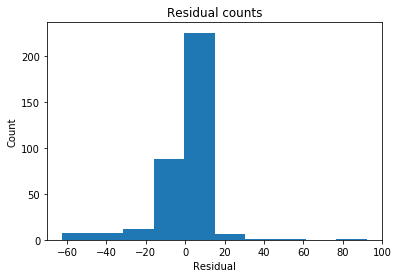

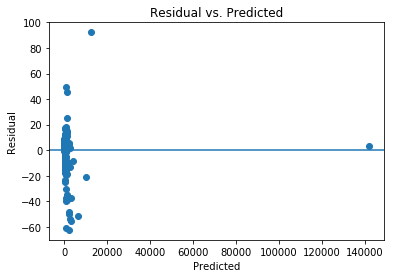

In [46]:
#Extract predicted values. - Why am I getting error? This is trying to check for multivariable normality and homoscdancity 
predicted = regr.predict(X).ravel()
actual = Y.ravel()

predicted2 = predicted.astype(float)
actual2 = actual.astype(float)

#Calculate the error, also called the residual.
residual = actual2 - predicted2

# Error histogram
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Error scatter plot
plt.scatter(predicted2, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [53]:
#Holdout Groups
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(actual2, predicted2, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(actual2, predicted2).score(actual2, predicted2).reshape(-1,1)))

ValueError: Expected 2D array, got 1D array instead:
array=[1.3000e+01 1.9900e+03 3.1100e+02 1.5200e+02 2.1000e+02 1.5600e+02
 8.0000e+00 3.1000e+01 2.0600e+02 1.1200e+02 1.0000e+00 4.4200e+02
 5.3000e+01 3.1500e+02 5.9000e+01 1.6000e+01 1.0000e+00 8.8000e+01
 4.2000e+01 6.8000e+01 1.6500e+02 1.0000e+01 3.6000e+01 6.1000e+01
 1.4360e+03 4.5000e+01 1.0270e+03 1.1800e+02 8.0600e+02 3.8000e+01
 3.4600e+02 9.9000e+01 1.0990e+03 9.0000e+01 0.0000e+00 8.0000e+00
 1.4000e+01 4.7000e+01 9.3300e+02 7.7000e+01 4.8300e+02 7.7000e+01
 1.8400e+02 4.6000e+01 1.0400e+03 2.1000e+01 1.1000e+02 9.4000e+01
 3.9000e+01 3.9000e+01 1.8000e+02 1.7300e+02 2.5000e+01 1.5000e+01
 4.6000e+01 2.6000e+01 2.8800e+02 1.9850e+03 1.6400e+02 3.4800e+02
 6.0000e+01 4.0000e+00 1.3000e+02 7.4000e+01 1.6200e+02 5.5900e+02
 3.6000e+01 2.1800e+02 4.7000e+01 1.9200e+02 5.8600e+02 9.4000e+01
 6.6000e+01 6.3000e+02 5.3300e+02 1.8000e+01 1.0000e+01 2.0800e+02
 8.0000e+01 1.3530e+03 6.7200e+02 1.2000e+01 5.8000e+01 2.4300e+02
 2.4000e+01 5.4000e+01 8.0000e+00 4.2000e+01 1.9000e+01 2.0000e+00
 9.9000e+01 2.4000e+01 1.0200e+03 6.0000e+01 1.0000e+01 3.1000e+01
 1.9100e+02 5.8000e+01 1.1400e+03 3.4300e+02 8.0000e+00 1.9000e+02
 4.1600e+02 4.0400e+02 5.1000e+01 9.5800e+02 1.1670e+03 6.8700e+02
 1.5900e+02 3.2500e+02 6.4000e+01 1.8500e+02 2.0000e+01 3.3000e+01
 1.6100e+02 8.5200e+02 5.4700e+02 1.6000e+01 1.3400e+02 7.1500e+02
 3.9800e+02 3.0000e+01 3.2000e+01 3.4600e+02 7.9300e+02 6.0400e+02
 3.1000e+02 8.4000e+01 1.5000e+01 2.0000e+00 6.8000e+01 2.7600e+02
 5.3000e+01 2.2000e+01 6.5000e+01 4.8900e+02 1.3530e+03 1.9800e+02
 8.6000e+01 3.7300e+02 4.6000e+01 3.9700e+02 1.9800e+02 4.4000e+01
 3.1300e+02 0.0000e+00 2.0000e+00 1.1100e+02 1.1650e+03 5.7100e+02
 1.2491e+04 1.4700e+02 9.0000e+00 5.8000e+01 1.8100e+02 4.0500e+02
 1.1000e+02 1.1300e+02 4.4000e+01 3.0000e+02 0.0000e+00 1.0000e+00
 1.2000e+01 3.4000e+02 8.7000e+01 5.9000e+01 1.2500e+02 1.1000e+01
 1.0100e+02 5.4100e+02 3.3000e+01 1.9000e+01 2.2500e+02 6.0000e+01
 1.0700e+02 2.3000e+01 4.1000e+01 7.2000e+01 8.2900e+02 1.6400e+02
 1.5150e+03 2.1300e+02 5.3000e+01 5.7200e+02 2.5100e+02 1.3000e+01
 1.4200e+02 3.1700e+02 2.3030e+03 5.8000e+01 5.6700e+02 1.5800e+02
 9.8000e+01 1.5000e+02 4.7100e+02 5.9300e+02 6.2000e+01 9.4900e+02
 9.0000e+00 2.5000e+01 5.9000e+01 3.2000e+01 1.2800e+02 1.3000e+01
 5.7000e+01 0.0000e+00 2.3680e+03 2.5000e+01 7.3000e+01 6.0000e+01
 6.4900e+02 2.4800e+02 1.0000e+01 2.2000e+02 5.7800e+02 2.9000e+01
 1.3100e+02 2.7100e+02 1.6200e+02 2.0000e+02 4.3400e+02 8.1000e+01
 1.0400e+02 2.4000e+01 8.3000e+01 3.3000e+01 2.0000e+01 2.2300e+02
 3.9000e+01 2.3490e+03 1.7900e+02 8.1000e+01 4.0900e+03 1.2000e+01
 2.9200e+02 1.8000e+01 1.1400e+02 5.8000e+01 1.2320e+03 1.4000e+01
 4.0200e+02 4.1000e+01 2.5280e+03 1.7000e+01 9.3000e+01 1.7200e+02
 2.8400e+02 6.6200e+02 7.8700e+02 4.1000e+01 1.2600e+02 3.5000e+01
 1.0800e+02 3.2000e+01 4.0000e+00 3.7900e+02 8.9600e+02 1.0000e+01
 2.2000e+01 1.3390e+03 3.3000e+01 3.8000e+01 4.1000e+02 4.6900e+02
 2.0800e+02 1.0600e+02 1.0051e+04 1.9000e+01 6.4200e+02 3.1500e+02
 5.0000e+00 1.0300e+02 1.5200e+02 7.1000e+01 2.4200e+02 2.8070e+03
 2.3000e+02 9.2200e+02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [54]:
model = regr.fit(X, Y)

from sklearn.model_selection import cross_val_score
cross_val_score(model, X, Y, cv=5)

array([0.99975547, 0.99906101, 0.99859186, 0.99981626, 0.99967575])